In [259]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from PIL import Image
import torch.nn.functional as F
from torchmetrics.image import StructuralSimilarityIndexMeasure

In [260]:
base_dir = 'img'

In [261]:
def normalize_and_scale(image, new_min=0, new_max=1):
    # Convert image to floating point
    image = image.astype(np.float32)
    # Scale image pixel values to desired range
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val) * (new_max - new_min) + new_min

In [262]:
def calculate_cosine_score(original_image, modified_image):
    # Convert the images to PyTorch tensors
    original_tensor = torch.tensor(original_image, dtype=torch.float32)
    modified_tensor = torch.tensor(modified_image, dtype=torch.float32)

    # Flatten the tensors to represent the images as vectors
    original_vector = original_tensor.flatten()
    modified_vector = modified_tensor.flatten()

    # Ensure the vectors have the same size
    max_size = max(original_vector.size(0), modified_vector.size(0))
    original_vector = F.pad(original_vector, (0, max_size - original_vector.size(0)), mode='constant', value=0)
    modified_vector = F.pad(modified_vector, (0, max_size - modified_vector.size(0)), mode='constant', value=0)

    # Calculate the cosine similarity
    cosine_similarity = F.cosine_similarity(original_vector.unsqueeze(0), modified_vector.unsqueeze(0), dim=1)

    return cosine_similarity.item()

In [263]:
def calculate_ssim_score(original_image, modified_image):
    # Convert the images to PyTorch tensors
    original_tensor = torch.from_numpy(np.array(original_image)).permute(2, 0, 1).unsqueeze(0).float()
    modified_tensor = torch.from_numpy(np.array(modified_image)).permute(2, 0, 1).unsqueeze(0).float()
    modified_tensor = F.interpolate(modified_tensor, size=original_tensor.shape[-2:], mode='bilinear', align_corners=True)
    
    if original_tensor.shape[1] != modified_tensor.shape[1]:
        modified_tensor = modified_tensor[:, :original_tensor.shape[1], :, :]

    # Calculate SSIM score
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
    ssim_score = ssim(original_tensor, modified_tensor)
    
    return ssim_score.item()

In [264]:
# Set the base directory
base_dir = 'img'

# Get the list of image files in the 'original' folder
original_folder = os.path.join(base_dir, 'original')
original_files = os.listdir(original_folder)

file_names = []
cosine_scores = []
ssim_scores = []

for original_file in original_files:
    # Construct the full file paths
    original_path = os.path.join(original_folder, original_file)
    modified_path = os.path.join(os.path.join(base_dir, 'modified'), original_file)

    # Load the images
    original_image = np.array(Image.open(original_path))
    modified_image = np.array(Image.open(modified_path))
    
    original_image_normalized = normalize_image(original_image)
    modified_image_normalized = normalize_image(modified_image)
    
    # Resize the smaller image to match the larger one
    original_size = original_image.shape[:2]
    modified_size = modified_image.shape[:2]
    if original_size != modified_size:
        if original_size[0] > modified_size[0] or original_size[1] > modified_size[1]:
            modified_image = np.array(Image.fromarray(modified_image).resize(original_size, resample=Image.BICUBIC))
        else:
            original_image = np.array(Image.fromarray(original_image).resize(modified_size, resample=Image.BICUBIC))

    # Calculate the cosine similarity score
    cosine_score = calculate_cosine_score(original_image, modified_image)
    cosine_scores.append(cosine_score)

    #Calculate SSIM
    ssim_score = calculate_ssim_score(original_image, modified_image)
    ssim_scores.append(ssim_score)

    # Calculate the SSIM score
    file_names.append(original_file)
    
    print(f"File: {original_file}, Cosine Similarity: {cosine_score}, SSIM: {ssim_score}")


File: 1.png, Cosine Similarity: 0.8999110460281372, SSIM: -12.601190567016602
File: 2.png, Cosine Similarity: 0.7618823647499084, SSIM: 0.030228547751903534
File: 3.png, Cosine Similarity: 0.7268241047859192, SSIM: 0.0233320165425539
File: 4.png, Cosine Similarity: 0.5170801877975464, SSIM: 0.05723929405212402
File: 5.png, Cosine Similarity: 0.507371187210083, SSIM: 0.2615782618522644
File: 6.png, Cosine Similarity: 0.6366869211196899, SSIM: 0.2009798288345337
File: 7.png, Cosine Similarity: 0.8816705942153931, SSIM: -12.367480278015137


In [265]:
with open('image_similarity_scores.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['File', 'Cosine Similarity', 'SSIM'])
    for i in range(len(file_names)):
        writer.writerow([file_names[i], cosine_scores[i], ssim_scores[i]])

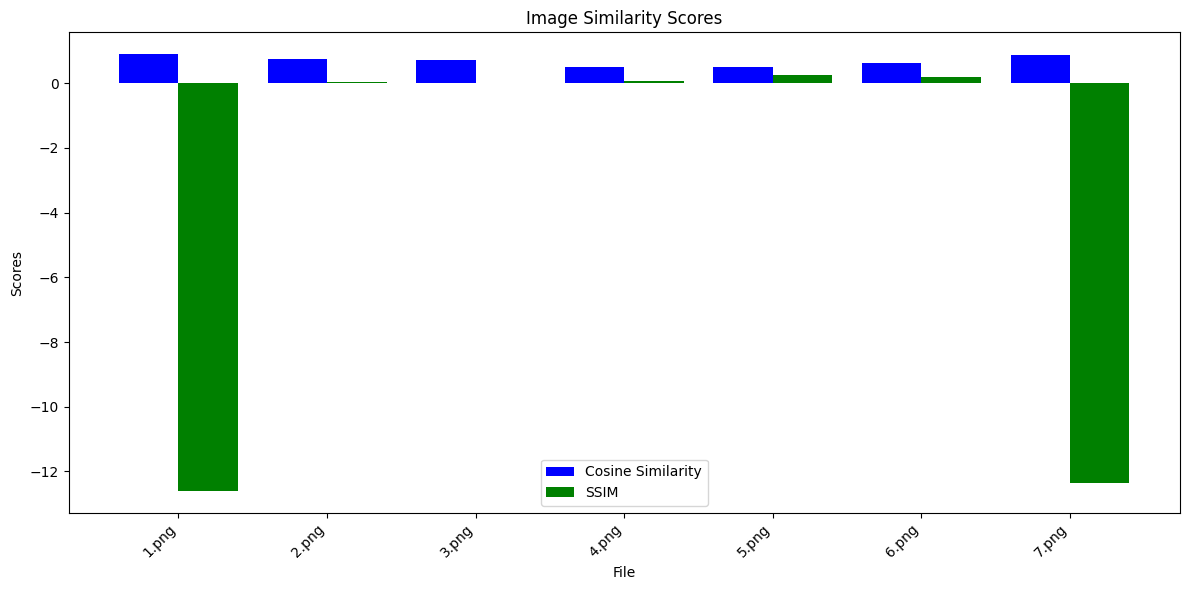

In [266]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(np.arange(len(file_names)) - 0.2, cosine_scores, width=0.4, color='b', label='Cosine Similarity')
ax.bar(np.arange(len(file_names)) + 0.2, ssim_scores, width=0.4, color='g', label='SSIM')

ax.set_xlabel('File')
ax.set_ylabel('Scores')
ax.set_xticks(np.arange(len(file_names)))
ax.set_xticklabels(file_names, rotation=45, ha='right')

ax.legend()
plt.title('Image Similarity Scores')
plt.tight_layout()
plt.savefig('image_similarity_plot.png')
plt.show()